In [1]:
import os
import rospy
import rosbag
import matplotlib.pyplot as plt
import matplotlib
import time
from cv_bridge import CvBridge, CvBridgeError

In [2]:
# Specify the path to the bag, and topic names
BAG_PATH = '../recording.bag'

# If you don't include the / you are done (smh...)
TOPIC_NAMES =['/racecar/camera/zed/rgb/image_rect_color', '/vesc/ackermann_cmd_mux/input/teleop'];

In [3]:
def loadMessages(bag_filename, topic_list):
    # specify topic and get messages
    # FIXME: Why does this function load only the first topic name in the list of topics?
    #START_TIME = rospy.Time(0)
    bagfile = rosbag.Bag(bag_filename)
    msgs = bagfile.read_messages(topics=topic_list)
    # create a dictionary that will store the messages in sequential order
    msg_dict= {}
    for tp in topic_list:
        msg_dict[tp]=[]
    
    for topic, msg, t in msgs:
        msg_dict[topic].append((msg,t))
    bagfile.close()
    
    return msg_dict


def process_image_topic(msg_dict,image_topic):
    # convert all the images to openCV Images 
    l1 = msg_dict[image_topic]
    #list for images and times 
    image_n_times=[]
    #define cv bridge
    cv_bridge=CvBridge()
    for (msg,tim) in l1:
        try:
            orig_image=cv_bridge.imgmsg_to_cv2(msg,"bgr8")
            image_n_times.append([orig_image,tim])
        except CvBridgeError as e:
            print(e)
    #return list of images and times
    return image_n_times

def synchronize_images_vesc(img_times_list,vesc_list,sync_slope=0.049,verbose=0):
    # create the list that will store our synchronized image
    # times and commands 
    sync_imgs =[]
    sync_commands=[]
     
    # start index for the vesc time
    start_index = 0
    # loop through the images and synchronize them with the 
    for img,tim in img_times_list:
        image_time = tim.to_sec()
        
        # for this image synchronize it with the msg
        # boolean that completes depending on whether the image was added or not
        added = False
        while (not added):
            # get the vesc command at the current index
            (vesc_command,vesc_command_time)=vesc_list[start_index]
            # convert the rostime to seconds
            vesc_command_time=vesc_command_time.to_sec()
            # compute the difference between when the image was 
            # captured and the steering command
            diff = image_time - vesc_command_time
            
            # if the difference is less than the desired threshold
            # given by sync_slope associate this command with the image
            if(abs(diff)<sync_slope):
                if (verbose):
                    print(diff,image_time,vesc_command_time)
                added=True
                # add the images and comands to respective lists
                sync_imgs.append(img)
                sync_commands.append(vesc_command.drive.steering_angle)
            # if the image came before the command, skip the image    
            elif(diff<0):
                break
            # if the command came before the image move to the next command
            elif(diff>0):
                start_index+=1
                
    return sync_imgs,sync_commands

In [4]:
# get all the messages from the bag based on the topic names
msg_dict_return=loadMessages(BAG_PATH,TOPIC_NAMES)

# define the IMAGE topic name and actuation command topic names
IMAGE_TOPIC = '/racecar/camera/zed/rgb/image_rect_color'
ACTUATION_TOPIC = '/vesc/ackermann_cmd_mux/input/teleop'

# get list of image and time stamps (list of tuples)
img_n_times= process_image_topic(msg_dict_return,IMAGE_TOPIC)

# get list of actuation commands (list of tuples)
commands_n_times= msg_dict_return[ACTUATION_TOPIC]

# synchronize the images and the 
imgs,commands=synchronize_images_vesc(img_n_times,commands_n_times,verbose=0)

# Load the neural network and make predictions

In [5]:
# import sys so we can use packages outside of this folder in
# either python 2 or python 3
import sys
sys.path.insert(0,'..')

#import other useful libraries
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.models import load_model
from preprocessing.utils import ImageUtils
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K  
%matplotlib inline

In [6]:
imgs= np.asarray(imgs).astype('float')
commands = np.asarray(commands)

#load the image utils
iu=ImageUtils()

# define the model 
MODEL = '../models/daev_accuracy.hdf5'
BATCH_SIZE =64 

# the model was trained with the custom metric so need to define it
def customAccuracy(y_true, y_pred):
    diff = K.abs(y_true-y_pred) #absolute difference between correct and predicted values
    correct = K.less(diff,0.01) #tensor with 0 for false values and 1 for true values
    return K.mean(correct) #sum all 1's and divide by the total. 


# load the model 
model=load_model(MODEL,custom_objects={'customAccuracy': customAccuracy})

#get the height and width from the model so we don't get annoying errors
height= model.layers[0].input_shape[1]
width =  model.layers[0].input_shape[2]

# normalize the imgs,reshape them, and normalize the commands
normalized_imgs=[]
commands = commands /0.6108652353
for img in imgs:
    img = img/255.0
    img=iu.reshape_image(img,height,width)
    normalized_imgs.append(img)
    
normalized_imgs=np.asarray(normalized_imgs)

# make the predictions 

predictions = model.predict(normalized_imgs, batch_size=BATCH_SIZE,verbose=1) 

acc=np.mean((commands-predictions)<0.01)
print("Accuracy: {}".format(acc))



2036/2036 [==============================] - 1s 377us/sample
Accuracy: 0.535530152732


# Plot the Results

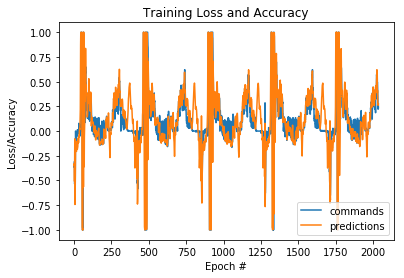

In [7]:
plt.figure()

plt.plot(np.arange(0,len(commands)),commands,label='commands')
plt.plot(np.arange(0,len(commands)),predictions,label='predictions')
plt.title("Predictions vs Ground Truth")
plt.xlabel("Time Step")
plt.ylabel("Normalized Steering Command (radians)")
plt.legend()
plt.show()

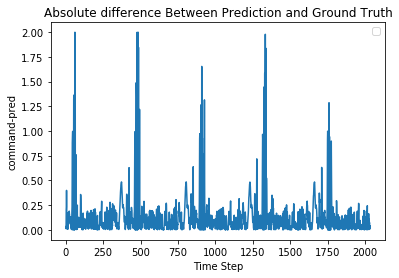

In [17]:
plt.figure()
diff= commands.flatten() - predictions.flatten()
plt.plot(np.arange(0,len(commands)),abs(diff))
plt.title("Absolute difference Between Prediction and Ground Truth")
plt.xlabel("Time Step")
plt.ylabel("command-pred")
plt.legend()
plt.show()